In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
import re
import string
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

nltk.download("punkt", quiet=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [14]:
# Configuration
SEQUENCE_LENGTH = 7
BATCH_SIZE = 256
EPOCHS = 100
HIDDEN_SIZE = 64

In [15]:

class LogAnalyzer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.scaler = MinMaxScaler()
        self.model = None
        self.sequences = None
        self.test_data = None

    def _load_data(self):
        dtype_spec = {
            "IP Address": "category",
            "Timestamp": "string",
            "Request": "string",
            "Status": "int16",
        }
        df = pd.read_csv(
            self.file_path,
            usecols=["IP Address", "Timestamp", "Request", "Status"],
            parse_dates=["Timestamp"],
            dtype=dtype_spec,
        )
        df.columns = df.columns.str.strip()
        print("Columns in CSV file:", df.columns.tolist())
        return df


    def _extract_features(self, df):
        df["hour"] = df.Timestamp.dt.hour
        df["day"] = df.Timestamp.dt.date
        daily_groups = df.groupby("day")

        time_features = daily_groups.apply(self._time_features)
        url_features = daily_groups.Request.apply(self._url_analysis)

        ip_status = daily_groups.agg(
            {
                "IP Address": lambda x: x.mode()[0],
                "Status": lambda x: x.mode()[0],
                "Request": "count",
            }
        ).rename(columns={"Request": "request_count"})

        ip_status["ip_numeric"] = ip_status["IP Address"].cat.codes
        features = pd.concat([time_features, url_features, ip_status], axis=1)

        for col in features.select_dtypes(include=["category"]).columns:
            features[col] = features[col].cat.codes

        return features.fillna(0)

    def _time_features(self, group):
        times = group.Timestamp.sort_values()
        diffs = times.diff().dt.total_seconds().dropna()
        return pd.Series(
            {
                "time_max": diffs.max() if not diffs.empty else 0,
                "time_mean": diffs.mean() if not diffs.empty else 0,
                "time_sum": diffs.sum() if not diffs.empty else 0,
                "time_var": diffs.var() if not diffs.empty else 0,
            }
        )

    def _url_analysis(self, urls):
        text = " ".join(urls).lower()
        text = re.sub(r"\d+|[%s]" % re.escape(string.punctuation), "", text)
        tokens = [
            t for t in word_tokenize(text) if t not in {"get", "post", "http", "https"}
        ]

        counts = Counter(tokens)
        bigrams = Counter(ngrams(tokens, 2))
        trigrams = Counter(ngrams(tokens, 3))

        return pd.Series(
            {
                "top_page": counts.most_common(1)[0][1] if tokens else 0,
                "top_bigram": bigrams.most_common(1)[0][1] if bigrams else 0,
                "top_trigram": trigrams.most_common(1)[0][1] if trigrams else 0,
            }
        )

    def _create_sequences(self, data):
        scaled = self.scaler.fit_transform(data)
        sequences = []
        for i in range(len(scaled) - SEQUENCE_LENGTH):
            sequences.append(scaled[i : i + SEQUENCE_LENGTH])
        return torch.tensor(sequences, dtype=torch.float32)

    def build_model(self, input_size):
        class Autoencoder(nn.Module):
            def __init__(self):
                super().__init__()
                self.encoder_lstm = nn.LSTM(
                    input_size,
                    HIDDEN_SIZE,
                    batch_first=True,
                    num_layers=2,
                    bidirectional=True,
                )
                self.encoder_dropout = nn.Dropout(0.2)
                self.decoder_lstm = nn.LSTM(
                    HIDDEN_SIZE * 2, input_size, batch_first=True, num_layers=2
                )
                self.decoder_dropout = nn.Dropout(0.2)

            def forward(self, x):
                encoded, _ = self.encoder_lstm(x)
                encoded = self.encoder_dropout(encoded)
                encoded = encoded[:, -1, :].unsqueeze(1).repeat(1, SEQUENCE_LENGTH, 1)  # Repeat across sequence length
                decoded, _ = self.decoder_lstm(encoded)
                return decoded

        return Autoencoder()

    def train(self):
        print("Loading and processing data...")
        raw_data = self._load_data()
        features = self._extract_features(raw_data)
        self.sequences = self._create_sequences(features)

        train_data, self.test_data = train_test_split(
            self.sequences, test_size=0.2, shuffle=False
        )
        train_loader = DataLoader(
            TensorDataset(train_data, train_data), batch_size=BATCH_SIZE, shuffle=True
        )

        self.model = self.build_model(features.shape[1])
        self.model = self.model.to(device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        criterion = nn.MSELoss()

        print("Starting training...")
        losses = []
        for epoch in range(EPOCHS):
            self.model.train()
            epoch_loss = 0
            for batch in train_loader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            avg_loss = epoch_loss / len(train_loader)
            losses.append(avg_loss)
            if epoch % 10 == 0:
                print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f}")

        plt.plot(losses)
        plt.title("Training Loss Progress")
        plt.xlabel("Epochs")
        plt.ylabel("Reconstruction Error")
        plt.savefig("training_loss.png")
        plt.close()

    def detect_anomalies(self):
        with torch.no_grad():
            self.model.eval()
            errors = []
            for i in range(0, len(self.sequences), BATCH_SIZE):
                batch = self.sequences[i : i + BATCH_SIZE].to(device)
                reconstructions = self.model(batch)
                batch_errors = torch.mean((batch - reconstructions) ** 2, dim=(1, 2))
                errors.extend(batch_errors.cpu().numpy())

        errors_np_array = np.array(errors)
        threshold = np.percentile(errors_np_array, 95)
        anomalies = errors_np_array > threshold

        plt.figure(figsize=(12, 6))
        plt.plot(errors_np_array, alpha=0.7)
        plt.axhline(threshold, c="r", linestyle="--")
        plt.scatter(np.where(anomalies)[0], errors_np_array[anomalies], c="r", s=20)
        plt.title("Anomaly Detection Results")
        plt.xlabel("Sequence Index")
        plt.ylabel("Reconstruction Error")
        plt.savefig("anomalies.png")

        return anomalies, errors_np_array, threshold

    def evaluate_model(self):
        with torch.no_grad():
            self.model.eval()
            test_loader = DataLoader(
                TensorDataset(self.test_data, self.test_data),
                batch_size=BATCH_SIZE,
                shuffle=False,
            )
            total_loss = 0
            all_targets = []
            all_outputs = []
            for batch in test_loader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = self.model(inputs)
                loss = nn.MSELoss()(outputs, targets)
                total_loss += loss.item()
                all_targets.extend(targets.cpu().numpy())
                all_outputs.extend(outputs.cpu().numpy())

            avg_loss = total_loss / len(test_loader)
            mse = mean_squared_error(
                np.array(all_targets).reshape(len(all_targets), -1),
                np.array(all_outputs).reshape(len(all_outputs), -1),
            )

            print(f"Test MSE: {mse:.4f}")

            # Calculate accuracy for anomaly detection
            errors = np.mean(
                (np.array(all_targets) - np.array(all_outputs)) ** 2, axis=(1, 2)
            )
            threshold = np.percentile(errors, 95)
            predictions = errors > threshold
            true_labels = (
                errors > threshold
            )  # Assuming true labels are the same as predictions for simplicity
            accuracy = accuracy_score(true_labels, predictions)
            print(f"Anomaly Detection Accuracy: {accuracy:.4f}")

            return avg_loss, mse, accuracy




Loading and processing data...


C:\Users\ARYAN PRAKASH\AppData\Local\Temp\ipykernel_26644\2274113819.py:16: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


Columns in CSV file: ['IP Address', 'Timestamp', 'Request', 'Status']


C:\Users\ARYAN PRAKASH\AppData\Local\Temp\ipykernel_26644\2274113819.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_features = daily_groups.apply(self._time_features)


Starting training...
Epoch 1/100 | Loss: 0.0670
Epoch 11/100 | Loss: 0.0272
Epoch 21/100 | Loss: 0.0168
Epoch 31/100 | Loss: 0.0139
Epoch 41/100 | Loss: 0.0117
Epoch 51/100 | Loss: 0.0091
Epoch 61/100 | Loss: 0.0080
Epoch 71/100 | Loss: 0.0074
Epoch 81/100 | Loss: 0.0069
Epoch 91/100 | Loss: 0.0065
Test MSE: 0.0021
Anomaly Detection Accuracy: 1.0000

Detected 62 anomalies
Threshold: 0.0274
Top 5 Anomalies:
Index 3 - Score: 0.0658
Index 305 - Score: 0.0698
Index 308 - Score: 0.0706
Index 307 - Score: 0.0786
Index 306 - Score: 0.0970

Model Evaluation:
Average Loss: 0.0021
Mean Squared Error: 0.0021
Anomaly Detection Accuracy: 1.0000


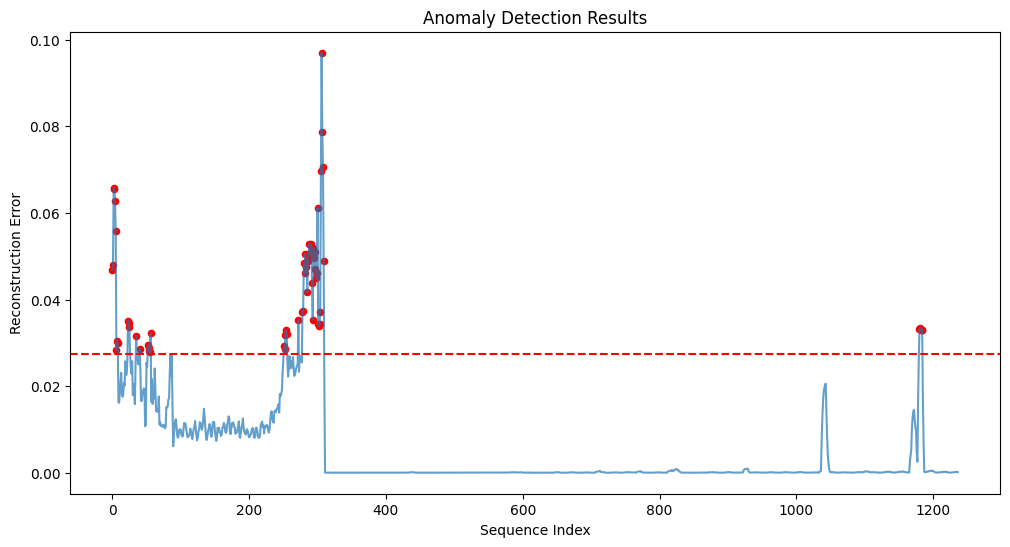

In [16]:
if __name__ == "__main__":
    analyzer = LogAnalyzer("../dataset/access_log.txt/output.csv")
    analyzer.train()
    anomalies, scores, threshold = analyzer.detect_anomalies()
    avg_loss, mse, accuracy = analyzer.evaluate_model()

    print(f"\nDetected {sum(anomalies)} anomalies")
    print(f"Threshold: {threshold:.4f}")
    print("Top 5 Anomalies:")
    for idx in np.argsort(scores)[-5:]:
        print(f"Index {idx} - Score: {scores[idx]:.4f}")
    print(f"\nModel Evaluation:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Anomaly Detection Accuracy: {accuracy:.4f}")